# Exploring Sentiment Analysis

Here we will look at using manhattan distance and cosine similarity to investigate Rotten Tomatoes movie reviews' sentiments as positive versus negative.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is i

In [2]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
from sklearn.linear_model import LogisticRegression

In [3]:
# Load dataset
# Shuffle the full training set, then take 1000 samples
dataset = load_dataset("rotten_tomatoes", split="train").shuffle(seed=42).select(range(2000))
df = pd.DataFrame(dataset)
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

,text,label
0,. . . plays like somebody spliced random momen...,0
1,michael moore has perfected the art of highly ...,1
2,. . . too gory to be a comedy and too silly to...,0
3,"a graceful , contemplative film that gradually...",1
4,the fact that the 'best part' of the movie com...,0


## Exploratory Data Analysis (EDA)
We'll examine the class distribution and sample reviews.

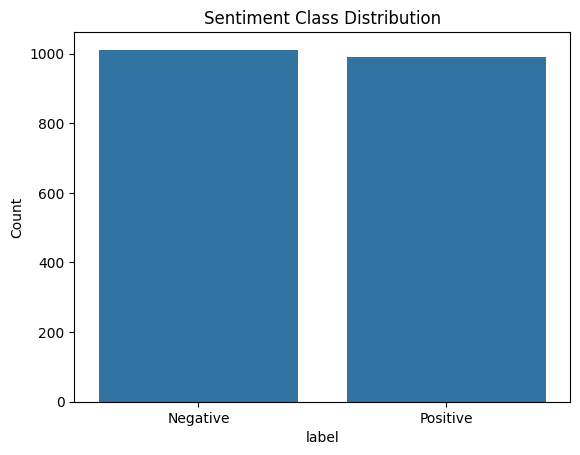

,proportion
label,
0,0.5055
1,0.4945


In [4]:
df['label'] = df['label'].astype(int)

sns.countplot(x='label', data=df)
plt.title('Sentiment Class Distribution')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.ylabel('Count')
plt.show()

df['label'].value_counts(normalize=True)

In [5]:
# Display sample reviews from each class
print("🔹 Sample Negative Reviews:")
print(df[df['label'] == 0]['text'].sample(3, random_state=1).to_string(index=False), "\n")

print("🔹 Sample Positive Reviews:")
print(df[df['label'] == 1]['text'].sample(3, random_state=2).to_string(index=False))

🔹 Sample Negative Reviews:
when it comes to the battle of hollywood vs . w...
the unceasing sadism is so graphically excessiv...
the best thing about the movie is its personabl... 

🔹 Sample Positive Reviews:
one of those rare films that come by once in a ...
        like a south-of-the-border melrose place .
it's about individual moments of mood , and an ...


## Step 1: Data Preprocessing
We will split the data into train and test sets and use `CountVectorizer` to transform the text into a sparse Bag-of-Words representation.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.3, random_state=42, stratify=df['label'])

# Bag-of-Words
vectorizer = CountVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

Vocabulary size: 6034


In [7]:
# Convert sparse matrix to DataFrame (for demonstration — only do this for small samples!)
sample_sparse_df = pd.DataFrame.sparse.from_spmatrix(X_train_vec[:5], columns=vectorizer.get_feature_names_out())
print("🔍 Sparse Matrix (Bag of Words) Sample:")
display(sample_sparse_df.head())

🔍 Sparse Matrix (Bag of Words) Sample:


,00,10,100,104,11,11th,12,13,15,15th,...,zellweger,zhang,zhao,zigzag,zingers,ziyi,zone,ótimo,último,única
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Step 2: Train KNN Classifier with Manhattan Distance
We use KNN with `k=5` and `metric='manhattan'` to classify sentiment based on word count patterns.

In [8]:
knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
knn.fit(X_train_vec, y_train)
y_pred = knn.predict(X_test_vec)

## Step 3: Model Evaluation
We evaluate the KNN classifier using accuracy, a classification report, and a confusion matrix.

In [9]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print(report)

Accuracy: 0.52
              precision    recall  f1-score   support

    Negative       0.51      0.97      0.67       303
    Positive       0.68      0.06      0.12       297

    accuracy                           0.52       600
   macro avg       0.60      0.52      0.39       600
weighted avg       0.60      0.52      0.40       600



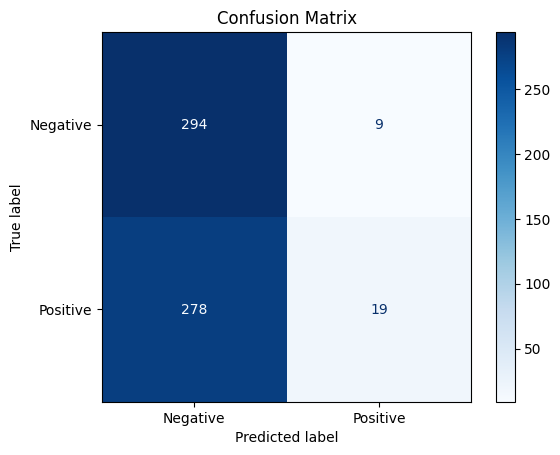

In [10]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Distance-Weighted KNN

**Let's see if a weighted KNN approach helps us.**

In [11]:
knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='distance')

knn.fit(X_train_vec, y_train)
y_pred = knn.predict(X_test_vec)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.51      0.97      0.67       303
    Positive       0.68      0.06      0.12       297

    accuracy                           0.52       600
   macro avg       0.60      0.52      0.39       600
weighted avg       0.60      0.52      0.40       600



**Let's also tune our k value.**

✅ Best k based on CV: 1 (Accuracy = 0.54)


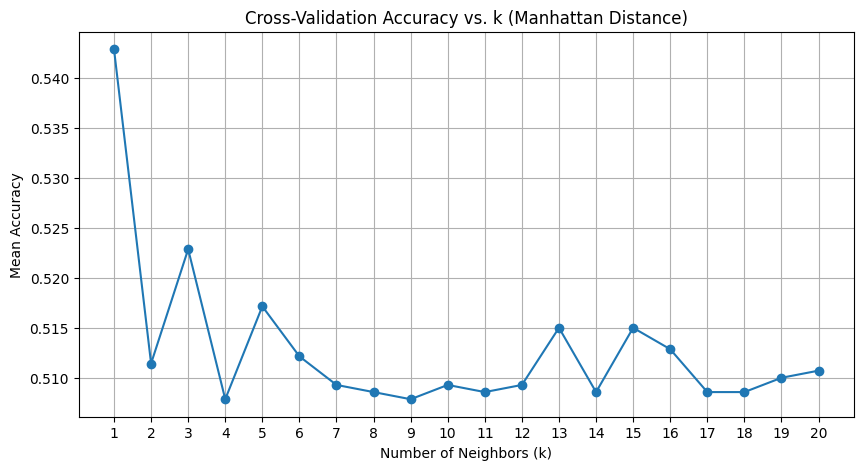

In [12]:
# Define the range of k values to test
k_values = range(1, 21)
cv_scores = []

# Loop over k values and compute mean cross-validation accuracy
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan', weights='uniform')  # or 'distance'
    scores = cross_val_score(knn, X_train_vec, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find best k
best_k = k_values[np.argmax(cv_scores)]
print(f"✅ Best k based on CV: {best_k} (Accuracy = {max(cv_scores):.2f})")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, cv_scores, marker='o')
plt.title("Cross-Validation Accuracy vs. k (Manhattan Distance)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Accuracy")
plt.grid(True)
plt.xticks(k_values)
plt.show()

## Other Approaches

1. KNN with Bag-of-Words + Cosine Distance

In [13]:
# Bag of Words
bow_vectorizer = CountVectorizer(stop_words='english')
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# Cosine distance (1 - cosine similarity)
knn_cos_bow = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_cos_bow.fit(X_train_bow, y_train)
y_pred_cos_bow = knn_cos_bow.predict(X_test_bow)

print("KNN with Bag-of-Words + Cosine Distance")
print(f"Accuracy: {accuracy_score(y_test, y_pred_cos_bow):.2f}")
print(classification_report(y_test, y_pred_cos_bow, target_names=['Negative', 'Positive']))

KNN with Bag-of-Words + Cosine Distance
Accuracy: 0.64
              precision    recall  f1-score   support

    Negative       0.66      0.60      0.63       303
    Positive       0.62      0.68      0.65       297

    accuracy                           0.64       600
   macro avg       0.64      0.64      0.64       600
weighted avg       0.64      0.64      0.64       600



2. KNN with TF-IDF + Manhattan Distance

In [14]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

knn_manh_tfidf = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
knn_manh_tfidf.fit(X_train_tfidf, y_train)
y_pred_manh_tfidf = knn_manh_tfidf.predict(X_test_tfidf)

print("KNN with TF-IDF + Manhattan Distance")
print(f"Accuracy: {accuracy_score(y_test, y_pred_manh_tfidf):.2f}")
print(classification_report(y_test, y_pred_manh_tfidf, target_names=['Negative', 'Positive']))

KNN with TF-IDF + Manhattan Distance
Accuracy: 0.51
              precision    recall  f1-score   support

    Negative       0.51      0.99      0.67       303
    Positive       0.67      0.03      0.05       297

    accuracy                           0.51       600
   macro avg       0.59      0.51      0.36       600
weighted avg       0.59      0.51      0.36       600



3. KNN with TF-IDF + Cosine Distance

In [15]:
knn_cos_tfidf = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_cos_tfidf.fit(X_train_tfidf, y_train)
y_pred_cos_tfidf = knn_cos_tfidf.predict(X_test_tfidf)

print("KNN with TF-IDF + Cosine Distance")
print(f"Accuracy: {accuracy_score(y_test, y_pred_cos_tfidf):.2f}")
print(classification_report(y_test, y_pred_cos_tfidf, target_names=['Negative', 'Positive']))

KNN with TF-IDF + Cosine Distance
Accuracy: 0.66
              precision    recall  f1-score   support

    Negative       0.67      0.66      0.66       303
    Positive       0.66      0.67      0.66       297

    accuracy                           0.66       600
   macro avg       0.66      0.66      0.66       600
weighted avg       0.66      0.66      0.66       600



### **Explore the Positive Review Issue**

In [16]:
false_negatives = X_test[(y_test == 1) & (y_pred_manh_tfidf == 0)]
for i, review in enumerate(false_negatives[:5]):
    print(f"Misclassified as Negative:\n{review}\n")

Misclassified as Negative:
ok arthouse . the power of this script , and the performances that come with it , is that the whole damned thing didn't get our moral hackles up .

Misclassified as Negative:
notwithstanding my problem with the movie's final half hour , i'm going to recommend secretary , based on the wonderful acting clinic put on by spader and gyllenhaal , and also the unique way shainberg goes about telling what at heart is a sweet little girl-

Misclassified as Negative:
for a good chunk of its running time , trapped is an effective and claustrophobic thriller .

Misclassified as Negative:
' . . . mafia , rap stars and hood rats butt their ugly heads in a regurgitation of cinematic violence that gives brutal birth to an unlikely , but likable , hero . '

Misclassified as Negative:
what redeems the film is the cast , particularly the ya-yas themselves .



In [19]:
correct_positives = X_test[(y_test == 1) & (y_pred_manh_tfidf == 1)]
for i, review in enumerate(correct_positives[:5]):
    print(f"Classified Correctly as Positive:\n{review}\n")

Classified Correctly as Positive:
with or without the sex , a wonderful tale of love and destiny , told well by a master storyteller

Classified Correctly as Positive:
campanella gets the tone just right -- funny in the middle of sad in the middle of hopeful .

Classified Correctly as Positive:
tadpole is a sophisticated , funny and good-natured treat , slight but a pleasure .

Classified Correctly as Positive:
not only is undercover brother as funny , if not more so , than both austin powers films , but it's also one of the smarter , savvier spoofs to come along in some time .

Classified Correctly as Positive:
hollywood ending is not show-stoppingly hilarious , but scathingly witty nonetheless .



### **Compare Nearest Neighbor**

In [20]:
# Number of positive test examples to show
N = 3  # 👈 Increase to show more comparisons

# Get positions of positive test examples
pos_indices = np.where(y_test.values == 1)[0][:N]

# Loop over the first N positive examples
for test_idx in pos_indices:
    print("=" * 80)

    # 1. Show test review
    test_review = X_test.iloc[test_idx]
    print(f"🟢 Test Review (True Label: Positive):\n\"{test_review}\"\n")

    # 2. Get vector
    test_vec = X_test_tfidf[test_idx]

    # 3. Compute distances to training set
    manh_dists = manhattan_distances(test_vec, X_train_tfidf).flatten()
    cos_dists = cosine_distances(test_vec, X_train_tfidf).flatten()

    # 4. Get top 5 neighbor indices
    top5_manh = np.argsort(manh_dists)[:5]
    top5_cos = np.argsort(cos_dists)[:5]

    # 5. Display function
    def show_neighbors(indices, dist_array, label_array, review_array, title):
        print(f"🔍 {title} Neighbors:")
        for i in indices:
            print(f"  Distance: {dist_array[i]:.3f} | Label: {'Positive' if label_array[i] == 1 else 'Negative'}")
            print(f"  Review: \"{review_array.iloc[i]}\"\n")

    # 6. Show Manhattan and Cosine neighbors
    show_neighbors(top5_manh, manh_dists, y_train.values, X_train, "Manhattan")
    show_neighbors(top5_cos, cos_dists, y_train.values, X_train, "Cosine")

🟢 Test Review (True Label: Positive):
"ok arthouse . the power of this script , and the performances that come with it , is that the whole damned thing didn't get our moral hackles up ."

🔍 Manhattan Neighbors:
  Distance: 2.812 | Label: Negative
  Review: "been there done that ."

  Distance: 2.812 | Label: Negative
  Review: "everything is off ."

  Distance: 3.160 | Label: Negative
  Review: "the script ? please ."

  Distance: 3.812 | Label: Negative
  Review: "crikey indeed ."

  Distance: 3.812 | Label: Positive
  Review: "one from the heart ."

🔍 Cosine Neighbors:
  Distance: 0.674 | Label: Negative
  Review: "the script ? please ."

  Distance: 0.758 | Label: Positive
  Review: "the funny thing is , i didn't mind all this contrived nonsense a bit ."

  Distance: 0.761 | Label: Negative
  Review: "i didn't laugh . i didn't smile . i survived ."

  Distance: 0.784 | Label: Negative
  Review: "according to the script , grant and bullock's characters are made for each other . but y